<small><i>(c) October 2016 - This notebook was created by [Oriol Pujol Vila](http://www.maia.ub.es/~oriol).</i></small>

# Gaussian discrimination and Gaussian processes

Outline:
+ Multivariate Gaussian distribution
+ Gaussian discrimination
+ Principal Component Analysis
+ Linear discriminant analysis


## 1. Multivariate Gaussian distributions and Principal Component Analysis

This notebook deals with continuous variables modelled as multivariate Gaussian distributions.

Let us recall the multivariate normal equation in D dimensions:


$$\mathcal{N}({\bf x}|{\bf \mu},\Sigma) = \frac{1}{(2 \pi)^{D/2}|\Sigma|^{1/2}}\exp[-\frac{1}{2}({\bf x}-{\bf \mu})^T\Sigma^{-1}({\bf x}-\mu)]$$


For the sake of completeness, let us check what this looks like in a 1D example.

In [1]:
import numpy as np

def gaussian_1d(x,mu,sigma):
    factor = 1./np.sqrt(2*np.pi*sigma*sigma)
    exponent = - (x-mu)*(x-mu)/(sigma*sigma)
    return factor*np.exp(exponent)

In [2]:
xmin=-6
xmax=6
x = np.linspace(xmin,xmax,200)

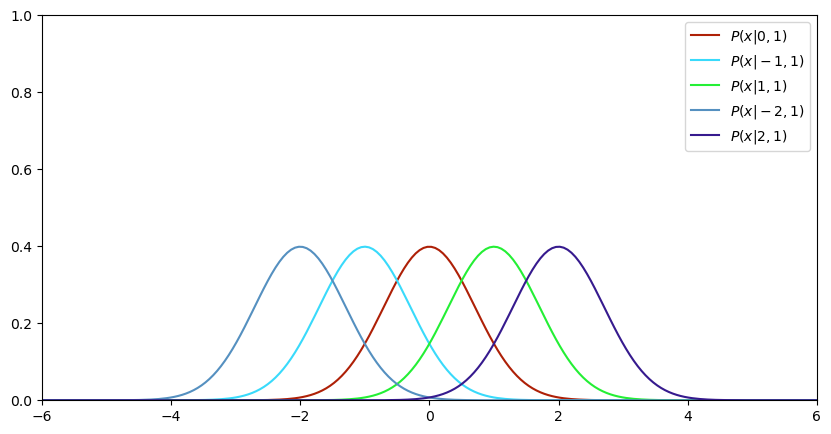

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(x,gaussian_1d(x,0,1),color = [np.random.rand(),np.random.rand(),np.random.rand()],label = '$P(x|0,1)$')
plt.plot(x,gaussian_1d(x,-1,1),color = [np.random.rand(),np.random.rand(),np.random.rand()],label = '$P(x|-1,1)$')
plt.plot(x,gaussian_1d(x,1,1),color = [np.random.rand(),np.random.rand(),np.random.rand()],label = '$P(x|1,1)$')
plt.plot(x,gaussian_1d(x,-2,1),color = [np.random.rand(),np.random.rand(),np.random.rand()],label = '$P(x|-2,1)$')
plt.plot(x,gaussian_1d(x,2,1),color = [np.random.rand(),np.random.rand(),np.random.rand()],label = '$P(x|2,1)$')
plt.legend()
plt.axis([xmin,xmax,0,1])
plt.gcf().set_size_inches((10,5))

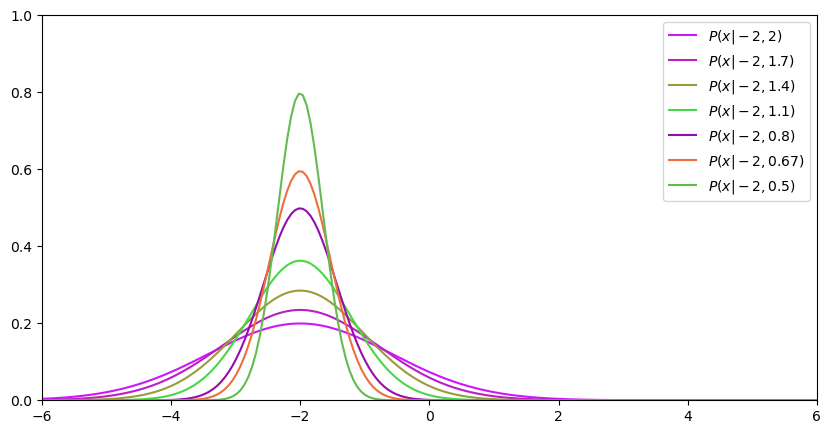

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(x,gaussian_1d(x,-2,2),color = [np.random.rand(),np.random.rand(),np.random.rand()],label = '$P(x|-2,2)$')
plt.plot(x,gaussian_1d(x,-2,1.7),color = [np.random.rand(),np.random.rand(),np.random.rand()],label = '$P(x|-2,1.7)$')
plt.plot(x,gaussian_1d(x,-2,1.4),color = [np.random.rand(),np.random.rand(),np.random.rand()],label = '$P(x|-2,1.4)$')
plt.plot(x,gaussian_1d(x,-2,1.1),color = [np.random.rand(),np.random.rand(),np.random.rand()],label = '$P(x|-2,1.1)$')
plt.plot(x,gaussian_1d(x,-2,0.8),color = [np.random.rand(),np.random.rand(),np.random.rand()],label = '$P(x|-2,0.8)$')
plt.plot(x,gaussian_1d(x,-2,0.67),color = [np.random.rand(),np.random.rand(),np.random.rand()],label = '$P(x|-2,0.67)$')
plt.plot(x,gaussian_1d(x,-2,0.5),color = [np.random.rand(),np.random.rand(),np.random.rand()],label = '$P(x|-2,0.5)$')

plt.legend()
plt.axis([xmin,xmax,0,1])
plt.gcf().set_size_inches((10,5))

### Understanding a multivariate Gaussian distribution

The expression inside the exponent is the Mahalanobis distance between the data vector $x$ and the mean vector $\mu$. Let us perform the eigendecomposition of $\Sigma$. We can write $\Sigma = U\Delta U^T$, with $U^TU = I$ (orthonormal matrix formed by the eigenvectors) and $\Delta$ is a diagonal matrix with the corresponding eigenvalues.

Because $U$ is orthogonal $U^{-1} = U^T$, then

$$\Sigma^{-1} = (U\Delta U^T)^{-1} = U^{-T}\Delta^{-1}U^{-1} = U\Delta^{-1}U^T$$

Because $\Sigma$ is positive definite all eigenvalues are positive, so are $\Sigma^{-1}$ eigenvalues. Thus

$$({\bf x}-{\bf \mu})^T\Sigma^{-1}({\bf x}-\mu)$$

is a quadratic form $x^T A x$. 

#### Quadratic forms

According to the eigenvalues of $A$ we can characterize the geometric properties of this equation. If all eigenvalues of $A$ are non-zero, then we have an *ellipsoid* or *hyperboloid*. If all eigenvalues are positive, it is an *ellipsoid* (if all are negative, we have an imaginary ellipsoid). If the signs are mixed, then we have a *hyperboloid*. If we have zero-value eigenvalues we are in front of a *paraboloid*. According to the rest of eigenvalues we may have a hyperbolic paraboloid or a elliptic paraboloid. 

In this case we are in front of an ellipsoid. Let us check this

In [5]:
#GAUSSIAN
import numpy as np
import copy
from sklearn.base import BaseEstimator

class Gaussian(BaseEstimator):
    def __init__(self,mean=None,cov=None):
        self.mean = mean 
        self.cov =  cov
        if cov.all()!=None:
            self.icov = np.linalg.pinv(self.cov)
    
    def fit_(self,X,y=None):
        self.mean = np.mean(X,axis=0)
        self.cov = np.cov(X,rowvar=False,bias = True)
        self.icov = np.linalg.pinv(self.cov)
    
    def fit(self,X,y):
        '''This is needed for compatibility with grid search CV and pipeline.
        When using this for modeling with data of just one class use fit_() method. 
        In that case target parameter is not needed.
        '''
        Xt=X[y==self.target,:]
        self.fit_(Xt)
    
    def predict(self,X):
        err = X-self.mean
        return np.where(-0.5*np.sum(np.dot(err,self.icov)*err,axis=1)>self.thr,1.,-1.)
    
    def predict_proba(self,X):
        err = X-self.mean
        return  np.exp(-0.5*np.sum(np.dot(err,self.icov)*err,axis=1))/np.sqrt(np.power((2*np.pi),self.mean.shape[0])*np.linalg.det(self.cov))
    
print ('DONE')

DONE


(10000, 2)


Text(0, 0.5, '$x_2$')

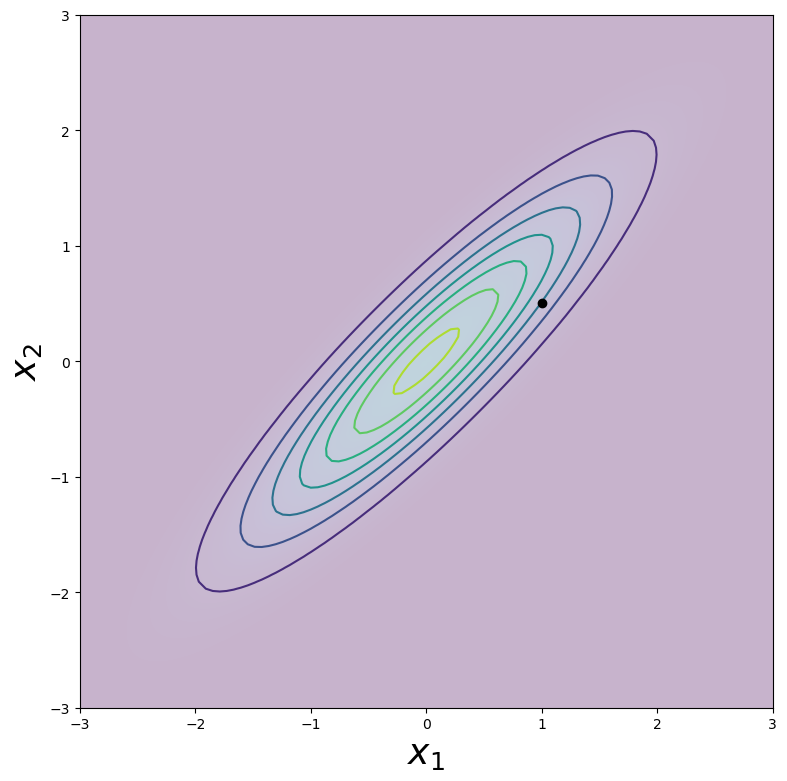

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
a = 0.9
K=np.array([[1,a],[a,1]])
g = Gaussian(cov=K, mean=np.array([0,0]))

xx = np.linspace(-3.,3.,100)
yy = np.linspace(-3.,3.,100)
[XX,YY] = np.meshgrid(xx,yy)
print (np.c_[XX.ravel(),YY.ravel()].shape)
Z = g.predict_proba(np.c_[XX.ravel(),YY.ravel()])

Z = Z.reshape(XX.shape)
plt.imshow(Z, interpolation='bilinear', origin='lower', extent=(XX.min(), XX.max(), YY.min(), YY.max()),alpha=0.3, vmin=0, vmax=1)
plt.contour(XX,YY,Z)
plt.plot(1,0.5,'ko',markersize=6)
fig = plt.gcf()
fig.set_size_inches(9,9)
ax = plt.gca()
ax.set_xlabel('$x_1$', size = 26)
ax.set_ylabel('$x_2$', size = 26)

Let us check the corresponding eigenvectors.

In [7]:
vaps,veps=np.linalg.eig(K)

In [8]:
veps,vaps

(array([[ 0.70710678, -0.70710678],
        [ 0.70710678,  0.70710678]]),
 array([1.9, 0.1]))

Text(0, 0.5, '$x_2$')

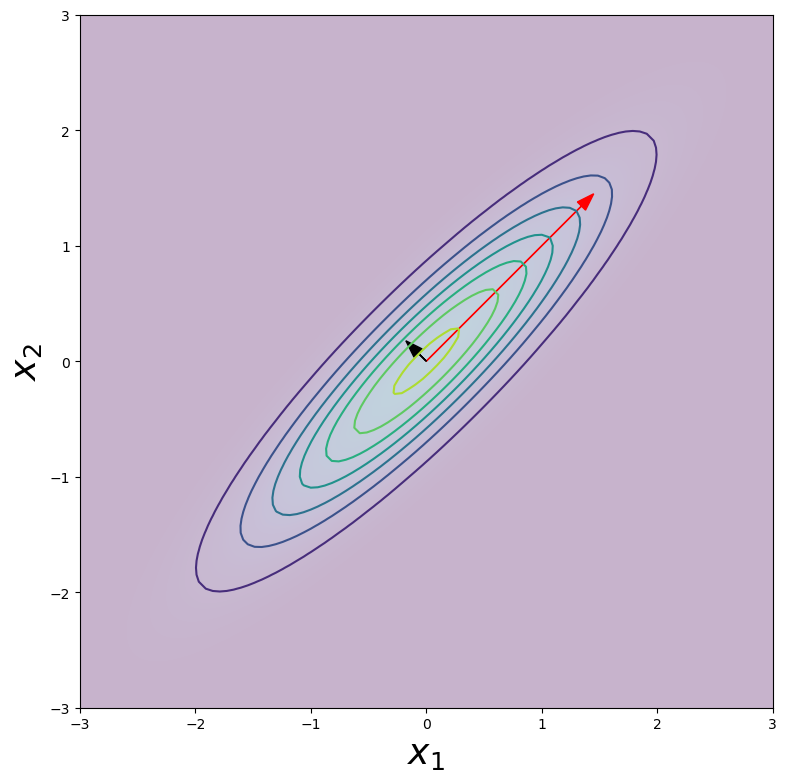

In [9]:


Z = Z.reshape(XX.shape)
plt.imshow(Z, interpolation='bilinear', origin='lower', extent=(XX.min(), XX.max(), YY.min(), YY.max()),alpha=0.3, vmin=0, vmax=1)
plt.contour(XX,YY,Z)
plt.arrow(0,0,vaps[0]*veps[0,0],vaps[0]*veps[1,0],linewidth=1,head_width=0.1,color='red')
plt.arrow(0,0,vaps[1]*veps[0,1],vaps[1]*veps[1,1],linewidth=1,head_width=0.1,color='black')
fig = plt.gcf()
fig.set_size_inches(9,9)
ax = plt.gca()
ax.set_xlabel('$x_1$', size = 26)
ax.set_ylabel('$x_2$', size = 26)

# Modelling data with a Gaussian distribution

We can think of modelling data using a Gaussian distribution. For this we can think of the parameters that maximize the Gaussian distribution, i.e. a maximum likelihood estimation.

$$\underset{\mu, \Sigma}{\text{maximize}}\quad p (D|\mu,\Sigma)$$

It can be proven that the ML estimator for those parameters is given by 

$$\mu^* = \frac{1}{N}\sum_i x_i$$
$$\Sigma^* = \frac{1}{N}\sum_i (x_i-\mu)^T(x_i-\mu)$$




Note that the covariance matrix estimation is a biased estimator when found using MLE.

Using this estimations we can now model data assuming that each class come from a Gaussian distribution and classify according to that model, this is called **gaussian discriminant analysis**. Formally, we are saying that the class conditional distribution 
$$p({\bf x}|y=c,\theta) = \mathcal{N}({\bf x}|\mu_c,\Sigma_c)$$

The posterior is given by:

$$p(y=c|x,\theta) = \frac{p(x|y=c,\theta)p(y=c|\theta)}{\sum_i p(x|y=c_i,\theta)p(y=c_i|\theta)}$$

And the classification rule can be stated as the maximum a posteriori

$$\underset{c}{\text{maximize}}\quad  p(y = c|x,\theta)$$




In the case of modeling data with Gaussian distributions and with all priors equal the problem is equivalent to considering the Mahalanobis distance, i.e. $d(a,b)  = (a-b)^T\Sigma^{-1}(a-b)$, to the centroid of the class.

If $\Sigma$ is diagonal, this model is equivalent to Naive Bayes.

This model is called **quadratic discriminant model or analysis**.

Given the following data set let us code a Gaussian discriminant analysis tool.

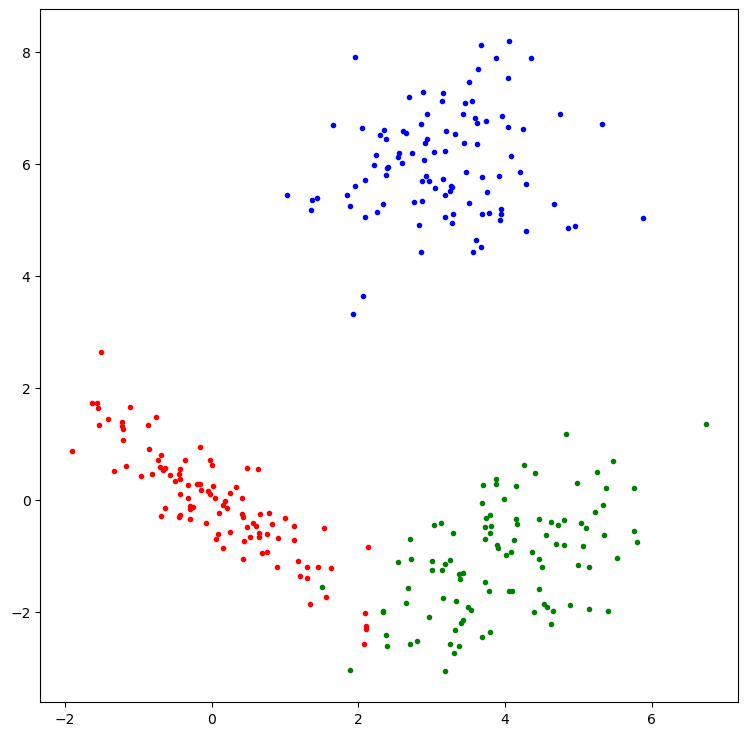

In [10]:
%matplotlib inline
import numpy as np
m1 = [0.,0.]
s1 = [[1,-0.9],[-0.9,1]]
m2 = [3.,6.]
s2 = [[1,0],[0,1]]
m3 = [4.,-1.]
s3 = [[1,0.5],[0.5,1]]

c1 = np.random.multivariate_normal(m1,s1,100)
c2 = np.random.multivariate_normal(m2,s2,100)
c3 = np.random.multivariate_normal(m3,s3,100)
import matplotlib.pyplot as plt


plt.plot(c1[:,0],c1[:,1],'r.')
plt.plot(c2[:,0],c2[:,1],'b.')
plt.plot(c3[:,0],c3[:,1],'g.')


plt.gcf().set_size_inches((9,9))


<div class = "alert alert-success" style = "border-radius:10px">**EXERCISE: ** Code the classifier and check the boundaries of the Gaussian discriminant classifier. Check the solution for different priors of the classes.</div>

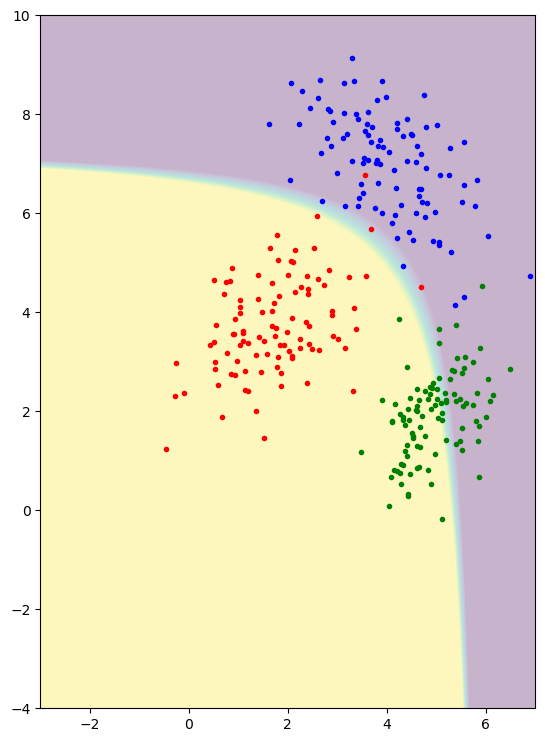

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Define the means and covariance matrices for each class
mean_c1 = np.array([2, 4])
cov_c1 = np.array([[1, 0.5], [0.5, 1]])

mean_c2 = np.array([4, 7])
cov_c2 = np.array([[1, -0.5], [-0.5, 1]])

mean_c3 = np.array([5, 2])
cov_c3 = np.array([[0.7, 0.3], [0.3, 0.8]])

# Generate synthetic data for each class
c1 = np.random.multivariate_normal(mean_c1, cov_c1, 100)
c2 = np.random.multivariate_normal(mean_c2, cov_c2, 100)
c3 = np.random.multivariate_normal(mean_c3, cov_c3, 100)

# Create data that covers the full space to explore
xx, yy = np.meshgrid(np.linspace(-3, 7, 200), np.linspace(-4, 10, 200))
viz = np.c_[xx.ravel(), yy.ravel()]

# Gaussian Discriminant Classifier
def gaussian_discriminant(x, mean, cov, prior):
    inv_cov = np.linalg.inv(cov)
    det_cov = np.linalg.det(cov)
    exponent = -0.5 * np.sum(np.dot(x - mean, inv_cov) * (x - mean), axis=1)
    return -0.5 * np.log(det_cov) + exponent + np.log(prior)

# Priors for each class
prior_c1 = 1/3
prior_c2 = 1/3
prior_c3 = 1/3

# Evaluate the classifier on the data stored in viz
discriminant_scores_c1 = gaussian_discriminant(viz, mean_c1, cov_c1, prior_c1)
discriminant_scores_c2 = gaussian_discriminant(viz, mean_c2, cov_c2, prior_c2)
discriminant_scores_c3 = gaussian_discriminant(viz, mean_c3, cov_c3, prior_c3)

# Combine the discriminant scores for visualization
z = discriminant_scores_c1 - discriminant_scores_c2  # You can customize this based on your problem

# Plot the data and decision boundaries
plt.plot(c1[:, 0], c1[:, 1], 'r.')
plt.plot(c2[:, 0], c2[:, 1], 'b.')
plt.plot(c3[:, 0], c3[:, 1], 'g.')
plt.gca().set_xlim([-3., 7.])
plt.gca().set_ylim([-4., 10.])
plt.imshow(z.reshape((200, 200)), interpolation='bilinear', origin='lower', extent=(-3, 7, -4, 10), alpha=0.3, vmin=-1, vmax=1)
plt.gcf().set_size_inches((9, 9))
plt.show()

# Principal component analysis

Using the same intuition of modeling data with a Gaussian distribution and considering the interpretation of the Gaussian model we can use this to **reduce dimensionality** when in front of a high dimensional problem. This is called *principal component analysis*. 

The basic idea is to project data just in a subset of the eigenvectors of the covariance matrix with larger eigenvalues so that the direccion of the maximum variation are preserved.

In this sense, we have to define the amount of dimensions to preserve. This can be either:

+ a fixed value set beforehand, 
+ the amount of that preserve some percentage of the "energy". Energy of a signal is related to the variance of the data. Thus from the full scaling defined by the eigenvalues we can preserve the amount of vectors such that the sum of the eigen values accounts for example to the 90% of the variation.


## A note on eigenvectors and eigenvalues

We have seen that the eigenvectors and eigenvalues 
Supose the following problem

$$\underset{w}{\text{maximize}}\quad\frac{w^T A w}{w^T w}$$

The solution of this problem can be analytically found using $\nabla_w =0$. Thus,

$$(Aw + (w^TA)^T )(w^Tw)^{-1} - 2 w^TAw w (w^Tw)^{-2} = 0$$

$$ Aw - w^TAw w (w^Tw)^{-1} = 0 $$

$$\frac{Aw}{w^TAw} = \frac{w}{w^Tw}$$

Note that the solution of the former problem corresponds to the eigenvector of maximum eigenvalue.


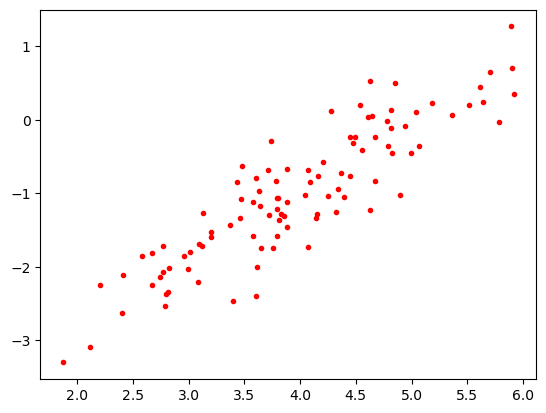

In [12]:
m1 = [4.,-1.]
s1 = [[1,0.9],[0.9,1]]
c1 = np.random.multivariate_normal(m1,s1,100)
plt.plot(c1[:,0],c1[:,1],'r.')

In [13]:
vaps,veps = np.linalg.eig(np.cov(c1.T))
P = veps

In [14]:
vaps

array([1.61344891, 0.09139709])

(-10.0, 10.0)

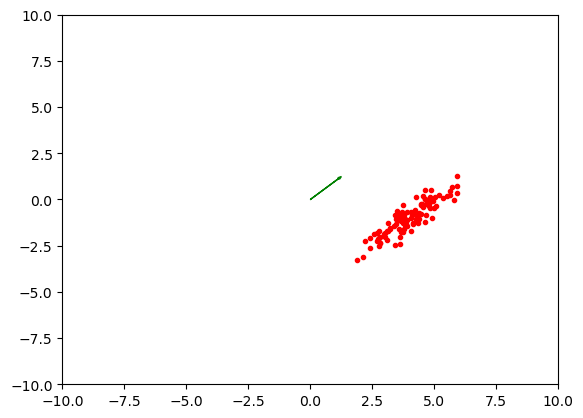

In [15]:
plt.plot(c1[:,0],c1[:,1],'r.')
plt.arrow(0,0,vaps[0]*veps[0,0],vaps[0]*veps[1,0],linewidth=1,head_width=0.1,color='green')
plt.gca().set_xlim([-10,10])
plt.gca().set_ylim([-10,10])

(-10.0, 10.0)

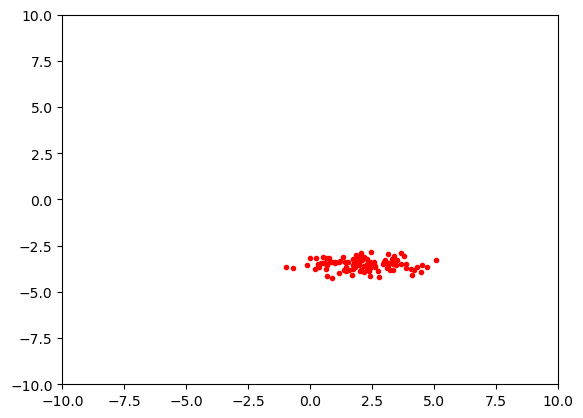

In [16]:
ct = np.dot(c1,P)
plt.plot(ct[:,0],ct[:,1],'r.')
plt.gca().set_xlim([-10,10])
plt.gca().set_ylim([-10,10])

In [1]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X=data.data
y=data.target
from sklearn import neighbors
from sklearn import model_selection

x_train, x_test, y_train, y_test =model_selection.train_test_split(X,y,test_size=0.3,random_state=42)
clf  = neighbors.KNeighborsClassifier(n_neighbors=1)
clf  = clf.fit(x_train,y_train)

clf.score(x_test,y_test)

0.935672514619883

In [38]:
x_train.shape

(398, 30)

<div class = "alert alert-success" style = "border-radius:10px">**EXERCISE: ** Code principal component analysis. Reduce the dimensionality to 5 dimensions and compute the classification score. Store the **HINT:** `numpy.linalg.eig` return the eigenvalues and eigenvectors decomposition.</div>

In [39]:
import numpy as np
from sklearn import neighbors
from sklearn import model_selection
from sklearn.datasets import load_breast_cancer

# Load the breast cancer dataset
data = load_breast_cancer()
X = data.data
y = data.target

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=42)

# Calculate the mean of the training set
x_train_mu = np.mean(x_train, axis=0)

# Center the training set
x_train_centered = x_train - x_train_mu

# Compute the covariance matrix
cov_matrix = np.cov(x_train_centered, rowvar=False)

# Calculate the eigenvalues and eigenvectors of the covariance matrix
vaps, veps = np.linalg.eig(cov_matrix)

# Sort eigenvectors based on eigenvalues in descending order
sorted_indices = np.argsort(vaps)[::-1]
veps = veps[:, sorted_indices]

# Choose the top 5 eigenvectors as principal components
P = veps[:, :5]

# Project the training data onto the reduced-dimensional space
x_hat_train = np.dot(x_train_centered, P)

# Project the test data onto the same reduced-dimensional space
x_test_centered = x_test - x_train_mu
x_hat_test = np.dot(x_test_centered, P)

# Train a k-nearest neighbors classifier on the reduced-dimensional training data
clf = neighbors.KNeighborsClassifier(n_neighbors=1)
clf = clf.fit(x_hat_train, y_train)

# Evaluate the classifier on the reduced-dimensional test data
score = clf.score(x_hat_test, y_test)
print("Classification Score:", score)

Classification Score: 0.935672514619883


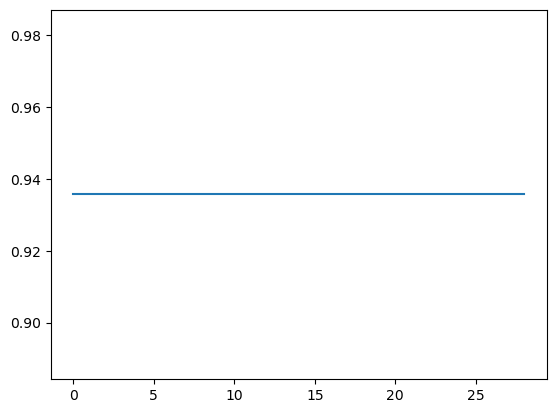

In [43]:
s = []
for i in range(1,veps.shape[1]):
    P = veps[:,:i]
    x_hat_train = np.dot(x_train,P)
    x_hat_test = np.dot(x_test,P)

    clf  = neighbors.KNeighborsClassifier(n_neighbors=1)
    clf  = clf.fit(x_hat_train,y_train)

    s.append(score)
    
plt.plot(s)

<div class = "alert alert-success" style="border-radius:10px"> **EXERCISE: ** 
<ol>
<li>
Consider problem 1 and answer the following question: Is the direction of the first principal component a good direction for discrimination purposes?</li>
<li> 
Consider problem 2 and answer the following question: Is the direction of the first principal component a good direction for discrimination purposes?</li>
</ol>
   
</div>

### Problem 1

[[1, 0.5], [0.5, 1]]


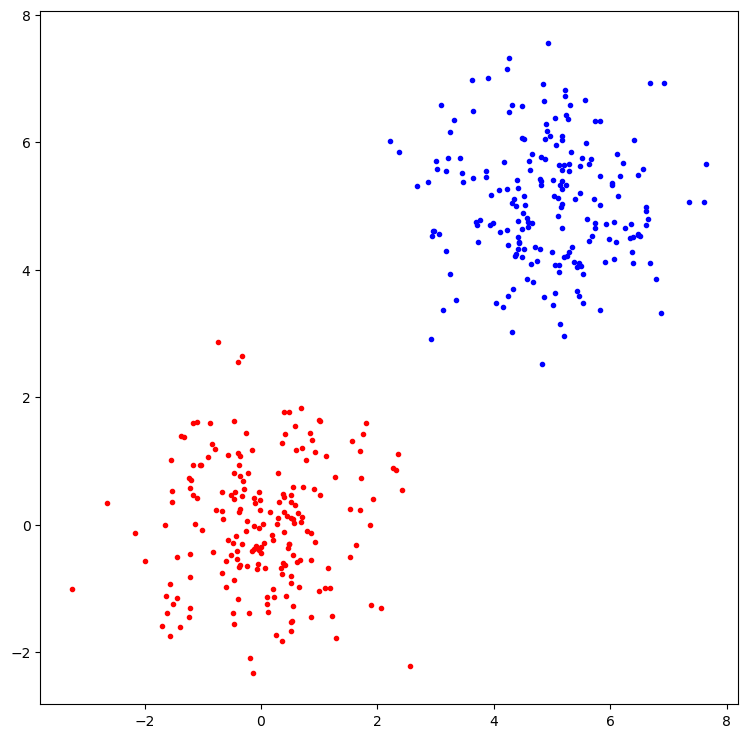

In [45]:
%matplotlib inline
import numpy as np
m1 = [0.,0.]
s1 = [[1,0],[0,1]]
m2 = [5.,5.]
s2 = [[1,0],[0,1]]

print (s3)
c1 = np.random.multivariate_normal(m1,s1,200)
c2 = np.random.multivariate_normal(m2,s2,200)
import matplotlib.pyplot as plt


plt.plot(c1[:,0],c1[:,1],'r.')
plt.plot(c2[:,0],c2[:,1],'b.')


plt.gcf().set_size_inches((9,9))

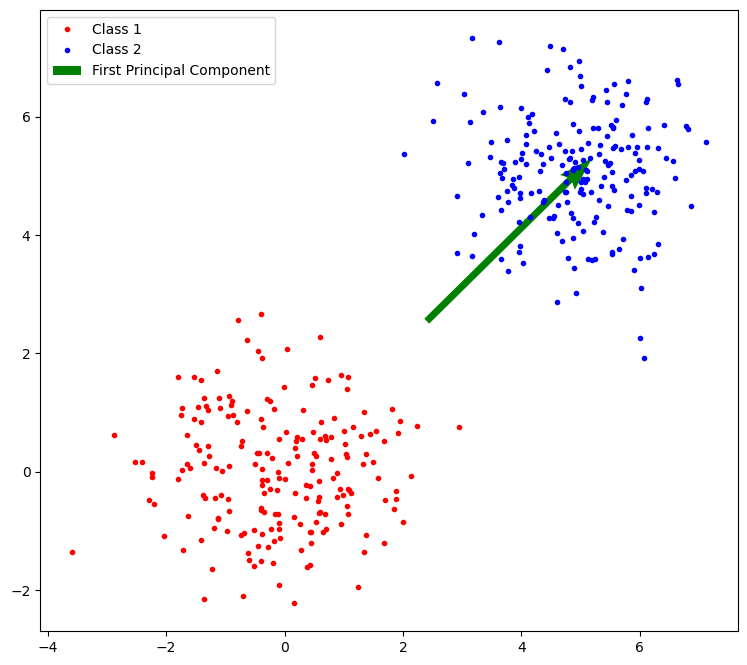

In [46]:
import numpy as np
import matplotlib.pyplot as plt

m1 = [0., 0.]
s1 = [[1, 0], [0, 1]]
m2 = [5., 5.]
s2 = [[1, 0], [0, 1]]

c1 = np.random.multivariate_normal(m1, s1, 200)
c2 = np.random.multivariate_normal(m2, s2, 200)

# Combine the two classes
data = np.concatenate([c1, c2])

# Center the data
data_centered = data - np.mean(data, axis=0)

# Compute the covariance matrix
cov_matrix = np.cov(data_centered, rowvar=False)

# Calculate the eigenvalues and eigenvectors
vaps, veps = np.linalg.eig(cov_matrix)

# Sort eigenvectors based on eigenvalues in descending order
sorted_indices = np.argsort(vaps)[::-1]
veps = veps[:, sorted_indices]

# Take the first principal component (eigenvector)
pc1 = veps[:, 0]

# Plot the data points
plt.plot(c1[:, 0], c1[:, 1], 'r.', label='Class 1')
plt.plot(c2[:, 0], c2[:, 1], 'b.', label='Class 2')

# Plot the first principal component as an arrow
plt.quiver(*np.mean(data, axis=0), *pc1, scale=3, color='g', width=0.01, label='First Principal Component')

plt.legend()
plt.gca().set_aspect('equal', adjustable='box')
plt.gcf().set_size_inches((9, 9))
plt.show()

### Problem 2

[[1, 0.5], [0.5, 1]]


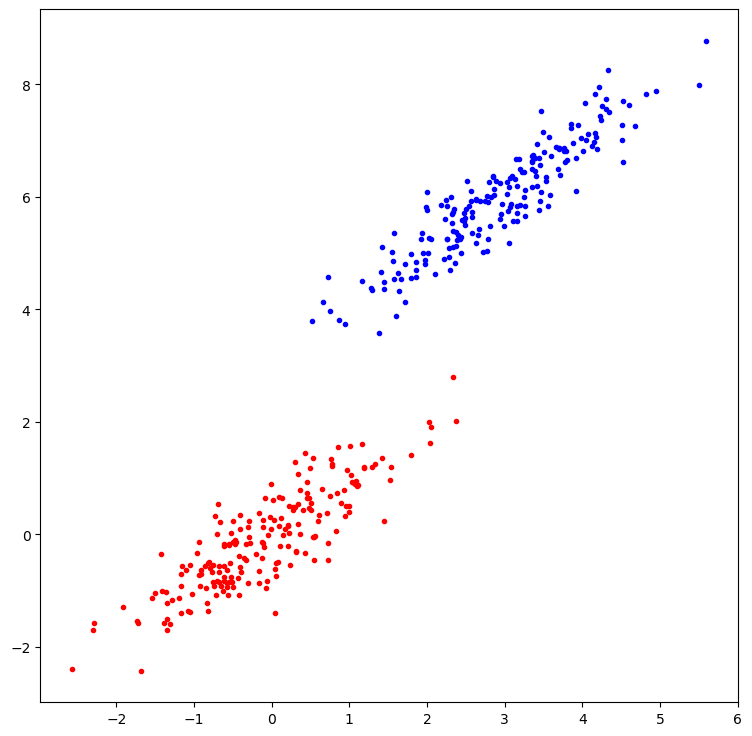

In [47]:
%matplotlib inline
import numpy as np
m1 = [0.,0.]
s1 = [[1,0.9],[0.9,1]]
m2 = [3.,6.]
s2 = [[1,0.9],[0.9,1]]

print (s3)
c1 = np.random.multivariate_normal(m1,s1,200)
c2 = np.random.multivariate_normal(m2,s2,200)
import matplotlib.pyplot as plt


plt.plot(c1[:,0],c1[:,1],'r.')
plt.plot(c2[:,0],c2[:,1],'b.')


plt.gcf().set_size_inches((9,9))

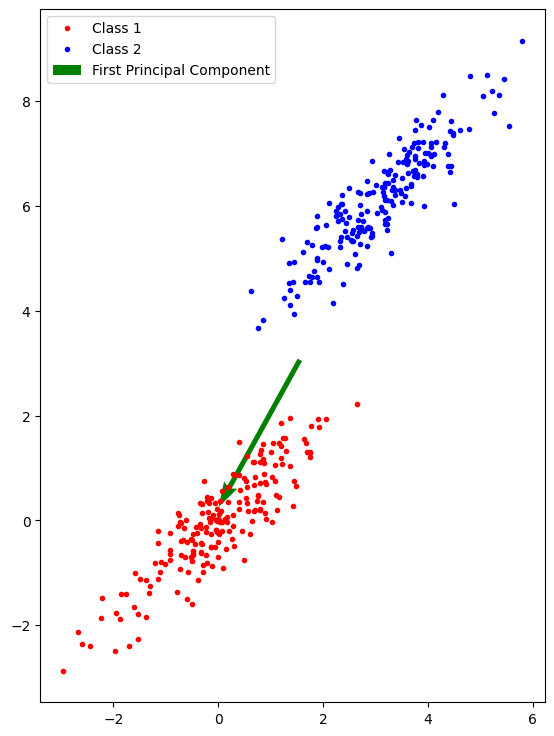

In [48]:
import numpy as np
import matplotlib.pyplot as plt

m1 = [0., 0.]
s1 = [[1, 0.9], [0.9, 1]]
m2 = [3., 6.]
s2 = [[1, 0.9], [0.9, 1]]

c1 = np.random.multivariate_normal(m1, s1, 200)
c2 = np.random.multivariate_normal(m2, s2, 200)

# Combine the two classes
data = np.concatenate([c1, c2])

# Center the data
data_centered = data - np.mean(data, axis=0)

# Compute the covariance matrix
cov_matrix = np.cov(data_centered, rowvar=False)

# Calculate the eigenvalues and eigenvectors
vaps, veps = np.linalg.eig(cov_matrix)

# Sort eigenvectors based on eigenvalues in descending order
sorted_indices = np.argsort(vaps)[::-1]
veps = veps[:, sorted_indices]

# Take the first principal component (eigenvector)
pc1 = veps[:, 0]

# Plot the data points
plt.plot(c1[:, 0], c1[:, 1], 'r.', label='Class 1')
plt.plot(c2[:, 0], c2[:, 1], 'b.', label='Class 2')

# Plot the first principal component as an arrow
plt.quiver(*np.mean(data, axis=0), *pc1, scale=3, color='g', width=0.01, label='First Principal Component')

plt.legend()
plt.gca().set_aspect('equal', adjustable='box')
plt.gcf().set_size_inches((9, 9))
plt.show()

Check the principal component.

[ 0.25524753 13.54541127]


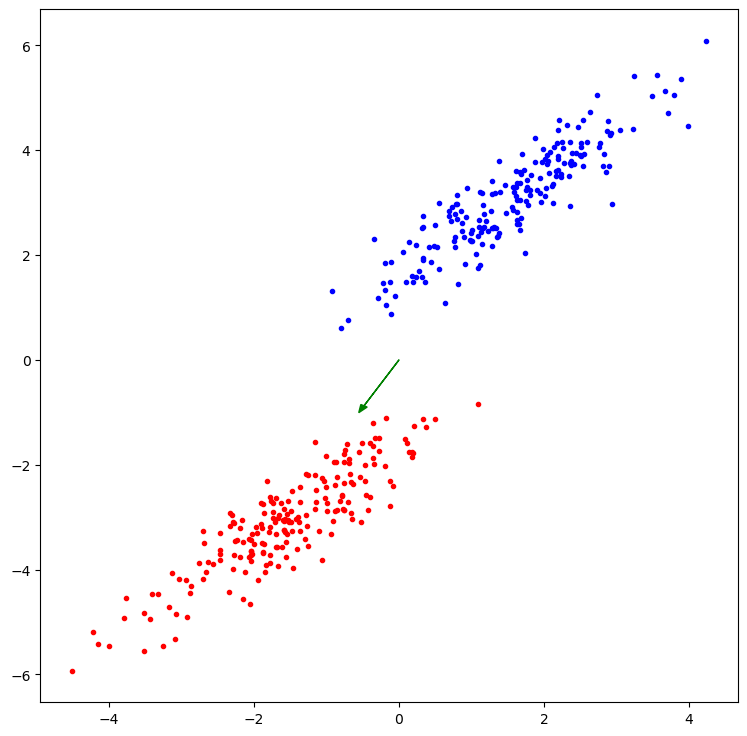

In [49]:
x = np.r_[c1,c2]
S = np.cov(x,rowvar=False)
vaps,veps=np.linalg.eig(S)

idx = np.argmax(vaps)
vep = veps[:,idx]
print (vaps)

m = np.mean(np.r_[c1,c2],axis=0)

plt.plot(c1[:,0]-m[0],c1[:,1]-m[1],'r.')
plt.plot(c2[:,0]-m[0],c2[:,1]-m[1],'b.')


plt.gcf().set_size_inches((9,9))
plt.arrow(0,0,vep[0],vep[1],linewidth=1,head_width=0.1,color='green')


## Fisher's linear discriminant analysis

Principal component analysis is purely an unsupervised technique that can be used to reduce dimensionality. In the case we have labels we could exploit that information to find a better projection in terms of discriminability. Fisher's linear discriminant analysis looks for that projection.

Remember that given any application $A$, the eigen vector correspon to the principal axis and the magnitude of the transformation of the application is given by the corresponding eigenvalue. This property can be used to maximize objective functions that can be written as linear operators by selecting the eigenvalue with maximum value. In this sense, if we look for the direction where data vary the most, we express the problem of variation and look for the eigenvector with maximum eigenvalue. 

We can take advantage of this and model different properties.

<div class = "alert alert-success" style="border-radius:10px"> **EXERCISE: ** 
Consider problem 2. What properties can we consider for finding a direction of maximum discriminability?
</div>

In Problem 2, where the covariance matrices have off-diagonal elements, finding a direction of maximum discriminability requires considering properties that capture the differences between the two classes more effectively. Some properties and techniques to consider for finding a direction of maximum discriminability include:

Fisher's Linear Discriminant (LDA):
Fisher's LDA seeks a projection that maximizes the distance between the means of different classes while minimizing the spread within each class. It explicitly aims to find a direction that maximizes the between-class variance relative to the within-class variance.

Mahalanobis Distance:
The Mahalanobis distance takes into account the correlation between variables and is sensitive to differences in variance and covariance. It can be used to measure the distance of a point from a distribution, considering the shape of the distribution.

Covariance Matrix Adaptation Evolution Strategy (CMA-ES):
Evolutionary algorithms, like CMA-ES, can be used to find directions that maximize a specific objective function. In the context of discriminability, this objective function might involve maximizing the separation between classes.

Kernel Methods:
Using kernel methods, such as kernel PCA or kernel Fisher discriminant analysis, can be beneficial when the relationship between variables is nonlinear. These methods implicitly map the data to a higher-dimensional space where linear separation might be more effective.

Regularized Discriminant Analysis (RDA):
RDA combines the ideas of LDA and ridge regression, introducing regularization to handle situations where the covariance matrices might be ill-conditioned.

Feature Engineering:
Creating new features or transforming existing ones based on domain knowledge can enhance discriminability. Feature engineering allows you to incorporate information that might not be captured by the original features.

Ensemble Methods:
Combining multiple classifiers or models can often improve discriminability. Ensemble methods, such as boosting or bagging, can be employed to integrate multiple weak learners into a strong learner.

In summary, finding a direction of maximum discriminability involves considering techniques that explicitly take into account the differences between classes, account for correlations between variables, and aim to maximize the separation in the chosen feature space. The choice of method depends on the characteristics of the data and the goals of the discrimination task.

Let us now define the following problem 

$$J(w) = \frac{w^T S_b w}{w^T S_w w}$$

where $S_b$ is the “between classes scatter matrix” and $S_w$ is the “within classes scatter matrix” defined as follows:

$$S_b = \sum_c (\mu_c-\bar{x})^T(\mu_c-\bar{x})$$

$$S_w = \sum_c \sum_{x_i : y_i = c} (x_i-\mu_c)^T(x_i-\mu_c)$$

Note that scatter matrices corresponds to the unnormalized covariance matrices.

The objective tries to push the centers of both classes as far appart from the center as possible by maximizing $S_b$. Additionally, minimizes the covariance of each of the classes individually.


[[1, 0.5], [0.5, 1]]


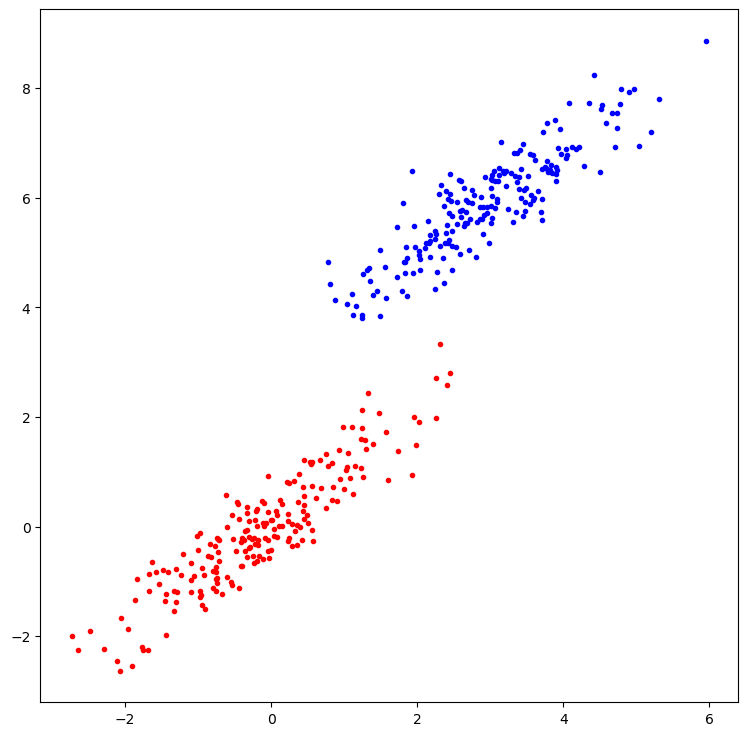

In [50]:
%matplotlib inline
import numpy as np
m1 = [0.,0.]
s1 = [[1,0.9],[0.9,1]]
m2 = [3.,6.]
s2 = [[1,0.9],[0.9,1]]

print (s3)
c1 = np.random.multivariate_normal(m1,s1,200)
c2 = np.random.multivariate_normal(m2,s2,200)
import matplotlib.pyplot as plt


plt.plot(c1[:,0],c1[:,1],'r.')
plt.plot(c2[:,0],c2[:,1],'b.')


plt.gcf().set_size_inches((9,9))

In [51]:
x_bar = np.mean(np.r_[c1,c2],axis=0)
mu_1 = np.mean(c1,axis=0)
mu_2 = np.mean(c2,axis=0)

m1x=mu_1-x_bar
m2x=mu_2-x_bar
Sb = np.dot(m1x[:,np.newaxis],m1x[:,np.newaxis].T)+np.dot(m2x[:,np.newaxis],m2x[:,np.newaxis].T)

Sw = np.dot((c1-mu_1).T,(c1-mu_1)) + np.dot((c2-mu_2).T,(c2-mu_2))

In [52]:
print (np.dot((c1-mu_1).T,(c1-mu_1)) /c1.shape[0])
print (np.cov(c1,rowvar=False))
print (Sb,np.cov(np.c_[mu_1,mu_2].T))

[[1.07316917 1.02889979]
 [1.02889979 1.18473697]]
[[1.07856198 1.03407014]
 [1.03407014 1.19069043]]
[[ 4.7421924   9.16097851]
 [ 9.16097851 17.69719998]] [[3.79010265e-03 1.28712089e-01]
 [1.28712089e-01 4.37106943e+00]]


In [53]:
A = np.dot(np.linalg.inv(Sw),Sb)

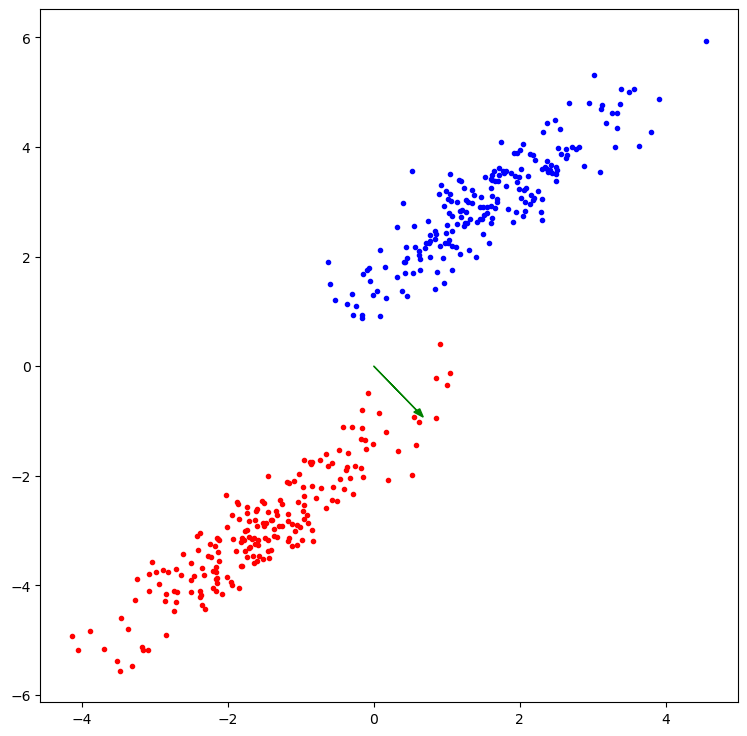

In [54]:
vaps,veps = np.linalg.eig(A)
vep = veps[:,np.argmax(vaps)]

m = np.mean(np.r_[c1,c2],axis=0)

plt.plot(c1[:,0]-m[0],c1[:,1]-m[1],'r.')
plt.plot(c2[:,0]-m[0],c2[:,1]-m[1],'b.')


plt.gcf().set_size_inches((9,9))
plt.arrow(0,0,vep[0],vep[1],linewidth=1,head_width=0.1,color='green')

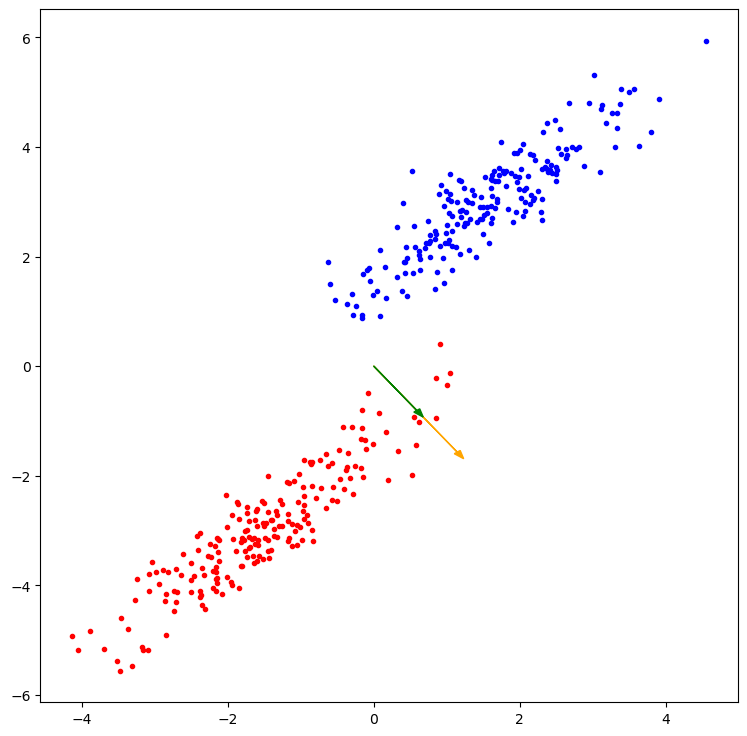

In [55]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
x = np.r_[c1,c2]
y = np.r_[np.ones((c1.shape[0],1)),-np.ones((c2.shape[0],1))]
clf = LinearDiscriminantAnalysis()
clf.fit(x,y.ravel())
coef = clf.coef_[0]
vep = veps[:,np.argmax(vaps)]

m = np.mean(np.r_[c1,c2],axis=0)

plt.plot(c1[:,0]-m[0],c1[:,1]-m[1],'r.')
plt.plot(c2[:,0]-m[0],c2[:,1]-m[1],'b.')


plt.gcf().set_size_inches((9,9))
plt.arrow(0,0,0.1*coef[0],0.1*coef[1],linewidth=1,head_width=0.1,color='orange')
plt.arrow(0,0,vep[0],vep[1],linewidth=1,head_width=0.1,color='green')

# Sequential Forward Floating Search

Sequential forward floating search is one of the algorithmic methods that uses a wrapper for selecting features. The main idea behind this kind of algorithms is to use a greedy or semi-greedy approach to selecting features. In this sense we can find three different approaches:

- Forward search: We start with an empty set, we train a model using just one feature at a time. We select the feature that has better predictive power. With that, we circle around for all features and add them one at a time to the current selected set. A classifier is trained for each configuration, and the one with the best performance is kept. This process is repeated for as many features as we want. Observe that this is a greedy process. As such, the solution is not the optimum.

- Backward search: The same as in the former case but removing features from the full set, instead of adding them.

- Floating search: It combines forward and backward, thus the name of floating. We first add, then we try to remove. This two part process is repeated while the performance increases. 

In [56]:
import pandas as pd
import numpy as np
import pickle

df = pd.read_csv('data/churn_curated_numerical.csv',header = None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,128.0,415.0,0.0,1.0,25.0,265.1,110.0,45.07,197.4,99.0,16.78,244.7,91.0,11.01,10.0,3.0,2.70,1.0,0.0
1,107.0,415.0,0.0,1.0,26.0,161.6,123.0,27.47,195.5,103.0,16.62,254.4,103.0,11.45,13.7,3.0,3.70,1.0,0.0
2,137.0,415.0,0.0,0.0,0.0,243.4,114.0,41.38,121.2,110.0,10.30,162.6,104.0,7.32,12.2,5.0,3.29,0.0,0.0
3,84.0,408.0,1.0,0.0,0.0,299.4,71.0,50.90,61.9,88.0,5.26,196.9,89.0,8.86,6.6,7.0,1.78,2.0,0.0
4,75.0,415.0,1.0,0.0,0.0,166.7,113.0,28.34,148.3,122.0,12.61,186.9,121.0,8.41,10.1,3.0,2.73,3.0,0.0


In [57]:
data = df.values
X = data[:,:-1]
y = data[:,-1]

In [58]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)

In [59]:
from sklearn import svm

clf = svm.SVC(gamma = 'scale')
clf.fit(X_train,y_train)

clf.score(X_test,y_test)

0.871

In [60]:
#Use forward selection without replacement 

N_features = 3
d=X_train.shape[1]
current_features = list(range(d))
selected_feat = []
selected_score = []
tmp_feat = []

for i in range(N_features):
    scores = []
    for feat in current_features:
        tmp_feat = selected_feat.copy()
        tmp_feat.append(feat)
        clf = svm.SVC(gamma = 'scale')
        clf.fit(X_train[:,tmp_feat],y_train)
        scores.append(clf.score(X_test[:,tmp_feat],y_test))
    selected_score.append(np.max(scores))
    selected_feat.append(current_features[np.argmax(scores)])
    current_features.pop(np.argmax(scores))
    print(current_features)

[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
[0, 1, 2, 3, 4, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17]
[0, 1, 2, 3, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17]


In [61]:
selected_score

[0.883, 0.894, 0.893]

In [62]:
selected_feat

[5, 8, 4]